# Analyzing environmental impacts of urban expansion in Phoenix, Arizona (2017-2020)

**Author**: Kat Le

**Github Repository**: https://github.com/katleyq/biodiversity-assessment-arizona

## About

The purpose of this analysis is to investigate the environmental impact of urban expansion in the Phoenix subdvision of Maricopa County, Arizona. Maricopa county has been experiencing rapid urban expansion since the early 2000s [1]. This analysis will investigate the impact of this urbanization on the environment through analyzing biodiversity in the study area. We will use the "Biodiversity Intactness Index" data developed by Gassert et al 2022 [2] to assess how biodiversity has changed between the years 2017 and 2020. 


## Highlights

In this analysis, we will accomplish the following:
- Retrieve Biodiversity Intactness Index (BII) data for our area of interest from the Microsoft Planetary Computer Data Catalog
- Compute raster stastistics of BII data
- Create data visualizations of BII data as a static plot and a time-series GIF 

## Data

1. **Phoenix Subdivision boundaries**: The original boundary data was retrieved from the US Census Bureau's 2020 Tiger / Line Shapefiles dataset. This dataset contains counties and subdivision boundaries from the US Census Bureau. It was subsetted for Phoenix and cleaned using `notebooks/phoenix-shapefile.ipynb`. (Original Source: [2020 Tiger/Line shapefiles](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions))

2. **Biodiversity Intactness Index (BII) Dataset**: This data was retrieved from the Microsoft Planetary Computer Data Catalogue. This dataset contains Biodiversity Intactness Index data from a model developed by Gassert et al in their project titled, "Global 100m Projections of Biodiversity Intactness for the years 2017-2020Global 100m Projections of Biodiversity Intactness for the years 2017-2020". (Original Source:  [Microsoft Planetary Computer Data Catalogue](https://planetarycomputer.microsoft.com/dataset/io-biodiversity))

## Data references
U.S. Census Bureau. (2020). 2020 TIGER/Line shapefiles: County subdivisions. Retrieved from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions

Gassert, F., et al. (n.d.). Global 100m projections of biodiversity intactness for the years 2017-2020. Microsoft Planetary Computer Data Catalogue. Retrieved from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

### Import necessary libraries

We will need the following libraries:

In [1]:
import pandas as pd # Manipulating dataframes
import numpy as np # Working with arrays
import geopandas as gpd # Work with spatial data
import matplotlib.pyplot as plt # Plotting
import matplotlib.lines as mlines # Custom legends for lines
import matplotlib.patches as mpatches  # for custom legend
import rioxarray as rioxr # Working with spatial dat arrays
from shapely.geometry import box # Computing bounding boxes
import contextily as ctx # Adding basemaps
from geogif import gif # Creating gifs
import stackstac # Creating stacks
import pystac_client # MPC client
from pystac_client import Client # To access STAC catalogues
import planetary_computer # To sign items from MPC STAC Catalogue
import rich.table # For table formatting

### Plot study area of analysis
In this section, we'll plot our area of interest.

In [2]:
# Read in Phoenix shapefile from phoenix-shapefile.ipynb
phoenix = gpd.read_file("../data/phoenix/phoenix.shp")

# Convert to EPSG 3857 in order to utilize ESRI WorldStreetMap basemap
phoenix = phoenix.to_crs(epsg=3857)

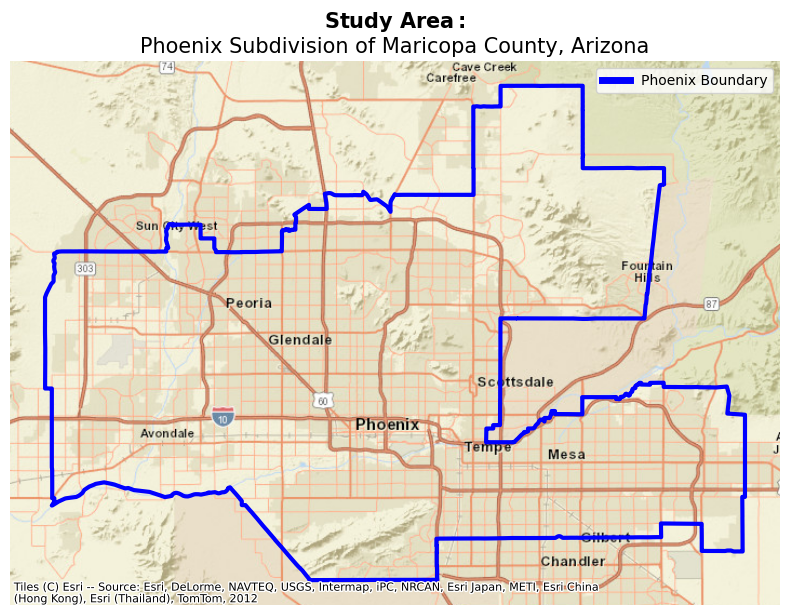

In [3]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Turn off axis
ax.set_axis_off()

# Plot the Phoenix data
phoenix.plot(ax=ax, facecolor='none', edgecolor='blue', 
             alpha=1, linewidth=3, zorder=2)

# Add a basemap from contextily 
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldStreetMap)

# Add title
ax.set_title(r"$\bf{Study\ Area:}$" "\nPhoenix Subdivision of Maricopa County, Arizona", size = 15)

# Create a custom legend entry for the blue line
phoenix_legend = mlines.Line2D([], [], color='blue', linewidth=5, label='Phoenix Boundary')

# Add the legend
ax.legend(handles=[phoenix_legend], 
          loc='upper right', 
          fontsize=10)


# Show plot
plt.tight_layout()
plt.show()

### Access Biodiverstiy Intactness Index data from Microsoft Planetary Computer
We use the `Client` function from the `pystac_client` package to access the catalog first. 

In [4]:
# Access MPC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

Next, we'll specify a bounding box and a time range for the search. We want an array of BII for each year from 2017-2020. We'll create a print statement to confirm what we're expected.

In [5]:
# Create bounding box for plotting
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Set time range of interest
time_range = "2017-01-01/2020-12-31"

search = catalog.search(collections=["io-biodiversity"], 
                        bbox=bbox_of_interest,
                        datetime=time_range)

# Retrieve items
items = search.item_collection()
print(f"This search retrieved {len(items)} items.")


This search retrieved 4 items.


# Biodiversity Intactness Index Data Exploration

In this next section, we'll explore the assets of the `items` object that we retrieved from the MPC catalogue search.

In [6]:
# Display all assets in items object
asset_table = rich.table.Table("Asset Key", "Asset Title")
for key, value in items[-1].assets.items():
    asset_table.add_row(key, value.title)
asset_table

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key        ┃ Asset Title                     ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data             │ Biodiversity Intactness         │
│ tilejson         │ TileJSON with default rendering │
│ rendered_preview │ Rendered preview                │
└──────────────────┴─────────────────────────────────┘

### Wrangling BII data
Now that we've completed the search, we'll want to format it so we can explore the data and plot it. 

First, we'll create a `stackstac` stack. `stackstac` is a faster way of loading a `stac` collection into local memory. We'll load BII data from 2017-2020 all into one object and create a year index.

In [7]:
# Create a stackstac stack of items collected from search
# Assign time coordinates and pull out year from datetime into new column
# Sort stack by time
stack = (
    stackstac.stack(items, bounds_latlon=bbox_of_interest, assets=["data"])
    .assign_coords(
        time=pd.to_datetime([item.properties["start_datetime"] for item in items]).year
        .to_numpy()
    )
    .sortby("time")
)

# Name new stack "Biodiversity Intactness"
stack.name = "Biodiversity Intactness"

In [8]:
# Remove dimensions with size 1 and load data arrays from stack
bii = stack.squeeze().compute()

In [9]:
# Display shape of BII
print(f"The dimensions of BII are: {bii.shape}")

print("--------")

# Display BII
print(f"The years we retrieved are: \n \n {bii.time}")

The dimensions of BII are: (4, 991, 1830)
--------
The years we retrieved are: 
 
 <xarray.DataArray 'time' (time: 4)> Size: 16B
array([2017, 2018, 2019, 2020], dtype=int32)
Coordinates: (12/13)
    id              (time) <U50 800B 'bii_2017_34.74464974521749_-115.3859782...
    band            <U4 16B 'data'
    proj:transform  object 8B {0.0, 1.0, 34.74464974521749, 0.000898315284119...
    proj:epsg       int64 8B 4326
    start_datetime  (time) <U20 320B '2017-01-01T00:00:00Z' ... '2020-01-01T0...
    end_datetime    (time) <U20 320B '2017-12-31T23:59:59Z' ... '2020-12-31T2...
    ...              ...
    version         <U2 8B 'v1'
    description     <U54 216B 'Terrestrial biodiversity intactness at 100m re...
    title           <U23 92B 'Biodiversity Intactness'
    raster:bands    object 8B {'sampling': 'area', 'data_type': 'float32', 's...
    epsg            int64 8B 4326
  * time            (time) int32 16B 2017 2018 2019 2020


## Results of data exploration


From the preliminary data exploration of `bii`, we learned that:
- we have 4 arrays in our `bii` object -  one array for each year between 2017-2020
- each of our 4 arrays is 991 by 1830 pixels
- our `bii` object is in the following CRS: EPSG 4326

# Biodiversity Intactness Index Data Analysis

In this next section, we'll analyze BII data then visualize it.

### Clipping BII data to area of interest

**CHECK**: Since we'll want to clip the BII data to only show the Phoenix subdvision, we'll want to make sure that both spatial datasets are in the same CRS.

We'll transform the CRS of the `phoenix` geodataframe to match the `bii` xarray object. 

For good measure, we'll include an assert statement to make sure that both of our spatial objects match.

In [10]:
# Transform CRS of phoenix polygon to match bii data
phoenix = phoenix.to_crs(bii.rio.crs)

In [11]:
# Make sure that both bii and phoenix crs match
assert bii.rio.crs == phoenix.crs

In [12]:
# Clip bii data to phoenix area
bii = bii.rio.clip(phoenix.geometry)

### Compute the percent area that is above 75% BII in the 2017 array

In [13]:
# Select array where time index is 2017
bii_2017 = bii.sel(time=2017)

# Select cells where BII is >= to 0.75 and store them as integer values for plotting
above75_2017 = (bii_2017 >= 0.75).astype(int)

# Add up all cells that have a value >= to 0.75
above75_2017_count = above75_2017.sum().item()

# Calculate total cells by counting all cells with data (so exclude NAs)
total_cells = bii_2017.count().item()

# Calculate percent of cells that have a value of >=0.75
print(f"BII 2017 - Percent area above 75%: {round((above75_2017_count / total_cells)*100, 2)}%")

BII 2017 - Percent area above 75%: 7.13%


### Compute the percent area that is above 75% BII in the 2020 array

In [14]:
# Select array where time index is 2020
bii_2020 = bii.sel(time=2020)

# Select cells where BII is >= to 0.75 and store them as integer values for plotting
above75_2020 = (bii_2020 >= 0.75).astype(int)

# Add up all cells that have a value >= to 0.75
above75_2020_count = above75_2020.sum().item()

# Calculate total cells by counting all cells with data (so exclude NAs)
total_cells = bii_2020.count().item()

# Calculate percent of cells that have a value of >=0.75
print(f"BII 2020 - Percent area above 75: {round((above75_2020_count / total_cells)*100, 2)}%")

BII 2020 - Percent area above 75: 6.5%


### Calculate the change in BII from 2017 to 2020

In [15]:
# Calcualte area with BII >=0.75 that were lost from 2017 to 2020
net_bii = above75_2017 - above75_2020

# Create a mask of cells with BII >=0.75 that were present in 2017 but loss in 2020
net_bii = net_bii == 1

### Visualize data

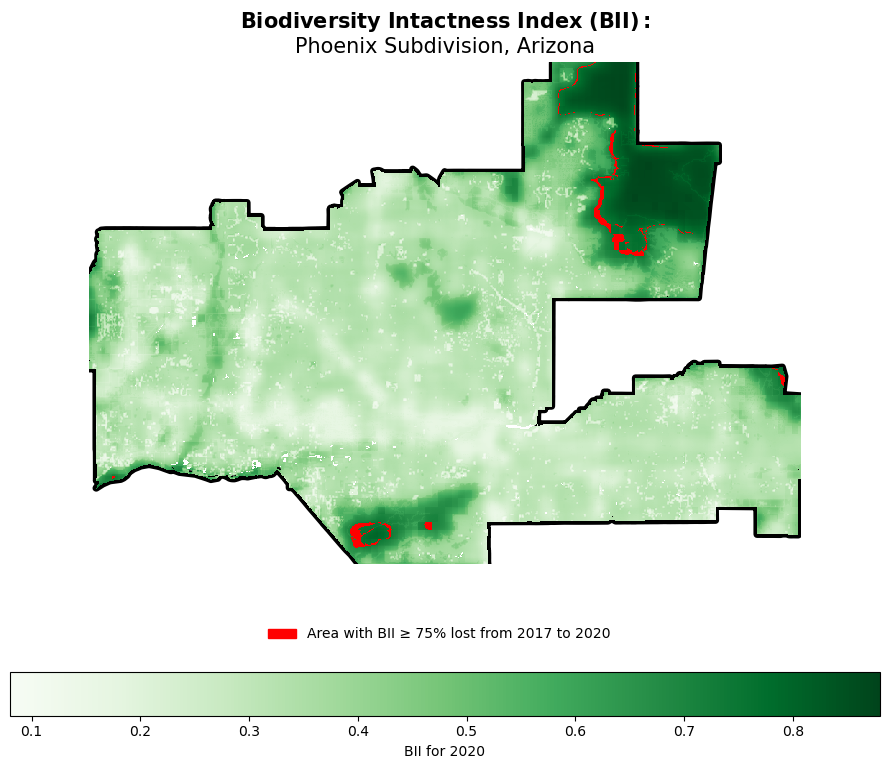

In [16]:
# Create the plot
fig, ax = plt.subplots(figsize=(9, 8))

# Turn off axis
ax.set_axis_off()

# Add Phoenix polygon for black border
phoenix.plot(ax = ax, color = 'none', edgecolor = 'black', linewidth=5, zorder=0)

# Add BII for 2020 and position it at the bottom with custom label
bii_2020.plot(ax=ax, cmap = "Greens", zorder = 1, 
             cbar_kwargs = {"label": "BII for 2020",
                            "location": "bottom"})

# Add net BII with no color for cells with 0 value and red for cells with value of 1
net_bii.plot(ax = ax, cmap = plt.cm.colors.ListedColormap(['none', 'red']), 
             add_colorbar = False)

# Create legend formatting for net BII
net_bii_legend = mpatches.Patch(color = "red",
                                label = "Area with BII ≥ 75% lost from 2017 to 2020")

# Add title
ax.set_title(r"$\bf{Biodiversity\ Intactness\ Index\ (BII):}$" "\nPhoenix Subdivision, Arizona", size=15)

# Add customized legend
ax.legend(handles = [net_bii_legend],
          frameon = False,
          bbox_to_anchor = (0.75, -0.1))


# Show plot
plt.tight_layout()
plt.show()

### Results from data visualization
The figure above shows the biodiversity intactness index levels for the Phoenix subdivision of Maricopa county, Arizona in 2020. The whiter areas of the plot indicate where biodiversity intactness is low. The darker green areas of the plot indicate places were biodiversity intactness is higher or healthier. The red polgyons indicate areas with BII >= 75% that were lost from 2017 to 2020. This plot shows that areas in the Phoenix subdivision that were previously considered more "intact" in terms of biodiversity, are starting to degrade and become less "intact".

### Creating GIF of BII from 2017-2020

In this final part, we will create a time-series visualization of how BII changes from 2017-2020. We'll create create a single stack containing BII data from each year then plot it as a GIF

In [17]:
# Create another BII stack with time in the datetime format for GIF
stack_gif = (
    stackstac.stack(items, bounds_latlon=bbox_of_interest, assets=["data"])
    .assign_coords(
        time=pd.to_datetime([item.properties["start_datetime"] for item in items])
        .tz_convert(None)
        .to_numpy()
    )
    .sortby("time")
)
stack_gif.name = "Biodiversity Intactness"

In [18]:
# Remove dimensions with size 1 and load data arrays from stack
bii_gif = stack_gif.squeeze().compute()

In [19]:
# Clip bii_gif to study area
bii_gif = bii_gif.rio.clip(phoenix.to_crs(bii_gif.rio.crs).geometry)

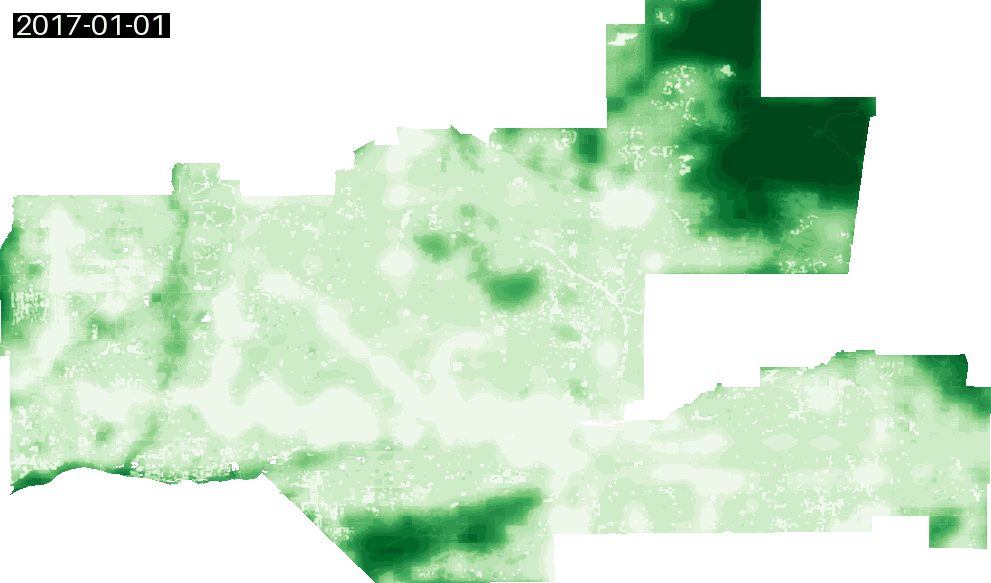

In [20]:
# Display GIF of BII from 2017-2020
gif(bii_gif, fps=1, cmap="Greens", robust=True)

## References

1. Z. Levitt and J. Eng, “Where America’s developed areas are growing: ‘Way off into the horizon’,” The Washington Post, Aug. 2021, Available: https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/. [Accessed: Nov. 22, 2024]

2. F. Gassert, J. Mazzarello, and S. Hyde, “Global 100m Projections of Biodiversity Intactness for the years 2017-2020 [Technical Whitepaper].” Aug. 2022. Available: https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf
